# KNIT7
# Upload and View the Timestamp Data In InfluxDB

## Prerequisites

##### The node to run the influxdb service must have **docker**, installed.
##### Make sure there is no docker containers named influxdb running on the nodes 

## Imports

In [ ]:
import json
import os
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager
from mflib.mf_timestamp import mf_timestamp 
try:
    fablib = fablib_manager()    
    fablib.show_config()
except Exception as e:
    print(f"Exception: {e}")

## Slice info

In [ ]:
# Change your slice name and node name(This is an example of a 3 node topology)
slice_name="Slice for KNIT7 Precision Timing Tutorial"
container_name="timestamp"
node1_name = 'node1'
node2_name = 'node2'
node3_name = 'node3'
node4_name = 'node4'

## Find all Experiment Nodes

In [ ]:
try:
    slice = fablib.get_slice(name=slice_name)
except Exception as e:
    print(f"Fail: {e}")

print (slice)    

try:
    node1 = slice.get_node(name=node1_name)
    node2 = slice.get_node(name=node2_name)
    node3 = slice.get_node(name=node3_name)
    node4 = slice.get_node(name=node4_name)
except Exception as e:
    print(f"Fail: {e}")

<font color=blue size="6">*Interacting With the Database*</font>

## Setup influxdb service on Node2 to store timestamp data

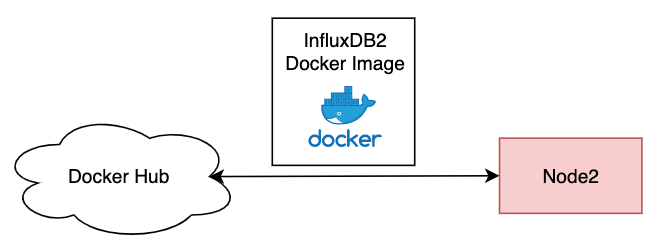

### Pull the influxdb image and run the docker container on Node2

In [ ]:
# Specify the influxdb bind mount volume
influxdb_bind_mount_volume="/home/ubuntu/influxdb"
cmd = f'''
      sudo docker run --privileged -d \
      -v {influxdb_bind_mount_volume}:/var/lib/influxdb2 \
      -e DOCKER_INFLUXDB_INIT_MODE=setup \
      -e DOCKER_INFLUXDB_INIT_USERNAME=my-user \
      -e DOCKER_INFLUXDB_INIT_PASSWORD=my-password \
      -e DOCKER_INFLUXDB_INIT_ORG=my-org \
      -e DOCKER_INFLUXDB_INIT_BUCKET=my-bucket \
      --network=host --privileged \
      --name influxdb influxdb:2.0
      '''
node2.execute(cmd)

### Check influxdb docker container on Node2 

In [ ]:
command = f"sudo docker ps"
stdout, stderr= node2.execute(command)

## Get influxdb info from Node2

### List influxdb info

In [ ]:
print ("List buckets")
command = f"sudo docker exec influxdb influx bucket list -o my-org"
stdout, stderr= node2.execute(command)

print ("\nList orgs")
command = f"sudo docker exec influxdb influx org list --json"
stdout, stderr= node2.execute(command)
try:
    org_id = str(json.loads(stdout)[0]["id"])
except Exception as e:
    print(f"Fail: {e}")

print ("\nList tokens")
command = f"sudo docker exec influxdb influx auth list --json"
stdout, stderr= node2.execute(command)

## Upload data to influxdb

### Load influx info

In [ ]:
try:
    token = str(json.loads(stdout)[0]["token"])
except Exception as e:
    print(f"Fail: {e}")
bucket = "my-bucket"
org="my-org"  
print (f"InfluxDB info: org: {org}, bucket: {bucket}, token: {token}")

### Upload packet and event data to influxdb

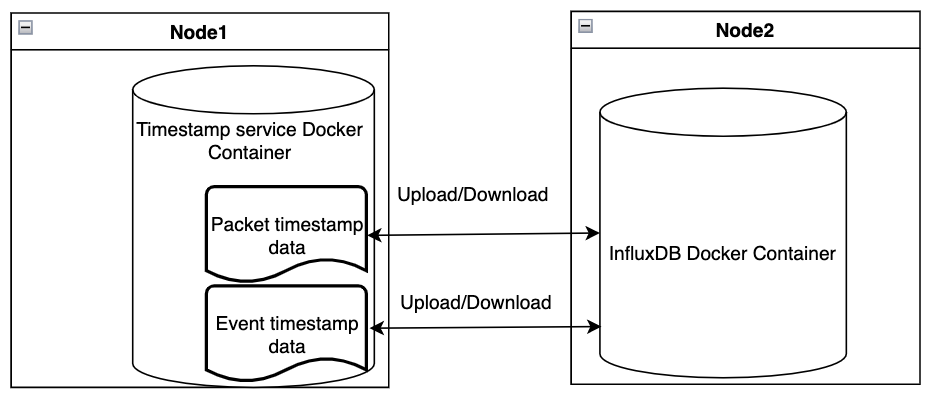

### Find the influxdb node IP

In [ ]:
# Specify which node influxdb is running on
influxdb_node_name=node2
# Specify the experiment network name you added on node2
node2_iface = node2.get_interface(network_name="net2") 
influxdb_ip=node2_iface.get_ip_addr()
print (influxdb_ip)

### Create object 

In [ ]:
container_name="timestamp"
ts = mf_timestamp(slice_name=slice_name, container_name=container_name)

### Upload timestamp data

In [ ]:
ts.upload_timestamp_to_influxdb(node=node1_name, data_type="packet_data", 
                                bucket=bucket, org=org, token=token, influxdb_ip=influxdb_ip)

In [ ]:
ts.upload_timestamp_to_influxdb(node=node1_name, data_type="event_data", 
                                bucket=bucket, org=org, token=token, influxdb_ip=influxdb_ip)

## If you want to see the json output

### Print packet data from influxdb

In [ ]:
# May run into IOPub data rate exceeded error if you have large data
packet_test_name="packet-test"
event_test_name="event-test"
ts.download_timestamp_from_influxdb(node=node1_name, data_type="packet_data", 
                                    bucket=bucket, org=org, token=token, 
                                    name=packet_test_name, influxdb_ip=influxdb_ip)

### Generate a .csv data file based on query on the Influxdb node

In [ ]:
query=ts.get_query_for_csv(data_node=node1_name, name=packet_test_name, data_type="packet_timestamp", 
                                bucket=bucket, org=org, token=token)
print (query)
node2.execute(query)

### Download the .csv file from influxdb

In [ ]:
# Specify jupyterhub path for the downloaed file
local_file=f"/home/fabric/work/influxdb_{node1_name}_packet_timestamp.csv"
ts.download_file_from_influxdb(data_node=node1_name, data_type="packet_timestamp", 
                               influxdb_node_name=node2_name,local_file=local_file)

### Inspect the data format from the .csv file

In [ ]:
import pandas as pd
df = pd.read_csv(local_file)
print(df.iloc[0])

### Print event timestamp data

In [ ]:
ts.download_timestamp_from_influxdb(node=node1_name, data_type="event_data", 
                                    bucket=bucket, org=org, token=token, 
                                    name=event_test_name, influxdb_ip=influxdb_ip)

## Visualize the influxdb web UI

In [ ]:
# Set up ssh tunneling to meas node
# ssh -L 10030:localhost:8086 -F ~/.ssh/fabric_ssh_config -i ~/.ssh/fabric_slice_key rocky@node2_management_ip 
local_port="10030"
influxdb_port="8086"
user = "ubuntu"
fabric_ssh_config_path= "ssh_config"
slice_key_path = "slice_key"
try:
    node2_management_ip=node2.get_management_ip()
except Exception as e:
    print(f"Fail: {e}")
print (f"SSH command to tunnel to node2 for influxdb:")
print (f"Go to the dir where you untar 'fabric_ssh_tunnel_tools.gz' and run the cmd to ssh into Node2")
print (f"ssh -L {local_port}:localhost:{influxdb_port} -F {fabric_ssh_config_path} -i {slice_key_path} {user}@{node2_management_ip}")
URL=f"http://localhost:{local_port}/orgs/{org_id}/data-explorer?bucket={bucket}"
print (f"Browse to {URL} to access InfluxDB web UI")

In [ ]:
# Username: my-user password: my-password
# If you are using Google Chrome to run this cell, you might encounter login loop
from IPython.display import IFrame
IFrame(URL, width=1200, height=1000)

### Upload Custom Dashboard

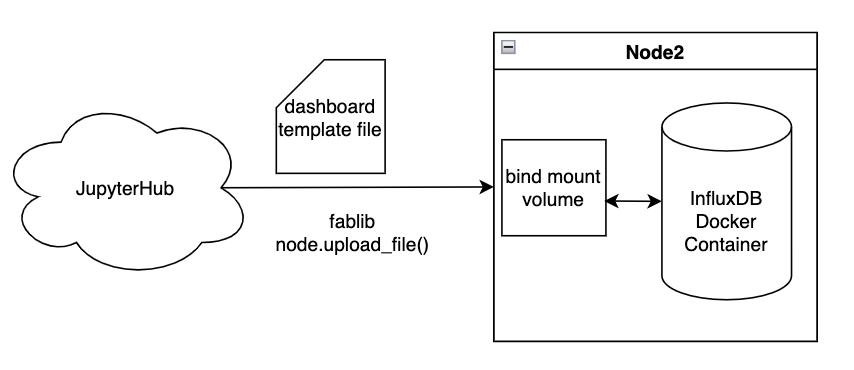

In [ ]:
# Use mf_timestamp to deploy dashboard template file
cwd = os.getcwd()
dashboard_file_relative_path = "dashboard_examples/influxdb/influxdb_timestamp_dashboard.yml"
dashboard_file_real_path = os.path.join(cwd, dashboard_file_relative_path)
ts.deploy_influxdb_dashboard(dashboard_file=dashboard_file_real_path,influxdb_node_name= node2_name, 
                             bind_mount_volume=influxdb_bind_mount_volume)

# Or
# Upload the dashboard file to the directory on meas_node that binds mount on influxdb container
#node2.upload_file(local_file_path=dashboard_file_real_path, remote_file_path="/home/rocky/influxdb/dashboard.yml")

# Apply the template in influxdb 
#command = f"sudo docker exec -i influxdb influx apply --skip-verify --file /var/lib/influxdb2/dashboard.yml"
#stdout, stderr= node2.execute(command)

## Optional: Stop the services 

In [ ]:
# Find the timestamp container id and stop the container
stdout=node1.execute("sudo docker ps -aqf 'name=timestamp'", quiet=True)
timestamp_container_id=stdout[0]
stdout,stderr= node1.execute(f"sudo docker container stop {timestamp_container_id}", quiet=True)

In [ ]:
# Find the influxdb container id and stop the container
stdout=node2.execute("sudo docker ps -aqf 'name=influxdb'", quiet=True)
influxdb_container_id=stdout[0]
stdout,stderr= node2.execute(f"sudo docker container stop {influxdb_container_id}", quiet=True)

## Optional: Remove the services

In [ ]:
timestamp_bind_mount_volume = "/home/ubuntu/timestamp/"
# Remove the container
stdout,stderr= node1.execute(f"sudo docker rm -v timestamp", quiet=True)
# Remove the timestamp docker image
stdout,stderr= node1.execute("sudo docker rmi -f fabrictestbed/timestamp:0.1.2")
# Remove the bind mount volume
stdout,stderr= node1.execute(f"sudo rm -rf {timestamp_bind_mount_volume}")

In [ ]:
# Remove the container
stdout,stderr= node2.execute(f"sudo docker rm -v influxdb", quiet=True)
# Remove the influxdb docker image
stdout,stderr= node2.execute("sudo docker rmi -f influxdb:2.0")
# Remove the bind mount volume
stdout,stderr= node2.execute(f"sudo rm -rf {influxdb_bind_mount_volume}")

In [ ]:
stdout,stderr= node1.execute("sudo docker ps -a")
stdout,stderr= node1.execute("sudo docker image ls")

In [ ]:
stdout,stderr= node2.execute("sudo docker ps -a")
stdout,stderr= node2.execute("sudo docker image ls")